# Smoothing

## Introduction

In this notebook, we will discuss various **smoothing** methods and example usages. Smoothing is usually applied to remove noise in the time series so that it is easier to see the underlying trend or patterns.


In [ ]:
# Import the usual things
from datetime import datetime
import numpy as np            
import pandas as pd            
import matplotlib.pylab as plt 
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# download air passenger data
!wget https://raw.githubusercontent.com/Pataweepr/scb_TS_course/master/AirPassengers.csv

--2021-07-27 09:18:28--  https://raw.githubusercontent.com/Pataweepr/scb_TS_course/master/AirPassengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1746 (1.7K) [text/plain]
Saving to: ‘AirPassengers.csv’

AirPassengers.csv   100%[===================>]   1.71K  --.-KB/s    in 0s      

2021-07-27 09:18:28 (30.3 MB/s) - ‘AirPassengers.csv’ saved [1746/1746]



---

# Section 1: simple smoothing

### What is Smoothing?
Any data collection process is subjected to noise. Oftentimes this noise can obscure useful patterns. Smoothing is a well-known and often used technique to extract those patterns. 

Smoothing comes in two main flavors:
1. Simple moving average
2. Exponential moving average

Let's first create some simple time series.

### Stationary time series

In [ ]:
# reproducibility
np.random.seed(42)

# Let's generate a random time series
time = np.arange(100)
stationary = np.random.normal(loc=0, scale=1.0, size=len(time))

Text(0, 0.5, 'series')

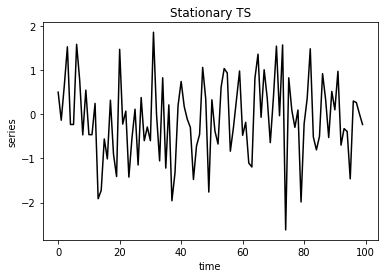

In [ ]:
plt.plot(time, stationary, 'k-')
plt.title('Stationary TS')
plt.xlabel('time')
plt.ylabel('series')

### Trend

Text(0, 0.5, 'series')

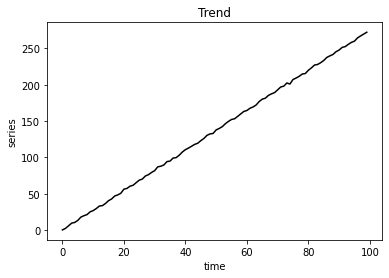

In [ ]:
trend = (time * 2.75) + stationary

plt.plot(time, trend, 'k-')
plt.title('Trend')
plt.xlabel('time')
plt.ylabel('series')

### Seasonality

Text(0, 0.5, 'series')

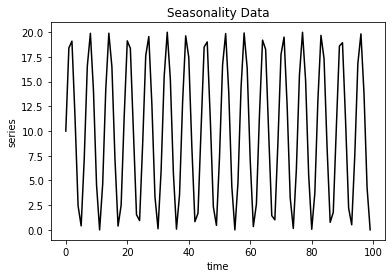

In [ ]:
seasonality = 10 + np.sin(time) * 10

plt.plot(time, seasonality, 'k-')
plt.title('Seasonality Data')
plt.xlabel('time')
plt.ylabel('series')

### Trend & seasonality

Text(0, 0.5, 'series')

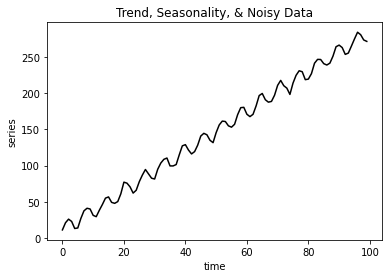

In [ ]:
trend_seasonality = trend + seasonality + stationary

plt.plot(time, trend_seasonality, 'k-')
plt.title('Trend, Seasonality, & Noisy Data')
plt.xlabel('time')
plt.ylabel('series')

### Exponentially increasing data

Text(0, 0.5, 'series')

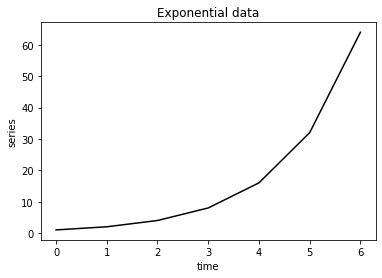

In [ ]:
t = np.arange(7)
exp_trend = 2**t

plt.plot(t, exp_trend, 'k-')
plt.title('Exponential data')
plt.xlabel('time')
plt.ylabel('series')

## Smoothing with moving average

Let's try smoothing the time series created with a simple moving average described below:

$S_{t} = \frac{y_{t} + y_{t-1} + ... + y_{t-n+1}}{n}$

$S_{t}$ is the smoothed value at time $t$
  
$n$ is a window size 

$y_{t}$ is the value of the series at time $t$

ex. $n$ = 3, $y$ = [1,2,3,4,5] --> [nan,nan,2,3,4]


In [ ]:
# A simple function that will calculate the average over a window.
# If used to forecast, simply extends the final value.
def moving_average(observations, window=3, forecast=False):
    '''returns the smoothed version of an array of observations.'''
    # This code might look unintuitive, but it works!
    # Try running the code line by line to understand the trick.
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    output = cumulative_sum[window - 1:] / window
    if forecast:
        return np.append(output, np.ones(3)*output[-1])
    else:
        return output

### Stationary time series

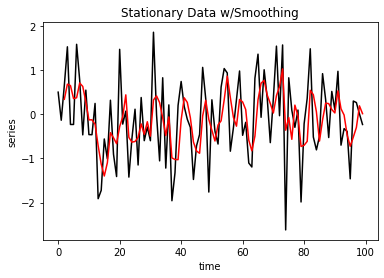

In [ ]:
smoothed_stationary = moving_average(stationary, window=3, forecast=False)

plt.plot(time, stationary, 'k-',label='Trend')
plt.title('Stationary Data w/Smoothing')
plt.xlabel('time')
plt.ylabel('series')
plt.plot(time[2:], smoothed_stationary, 'r', label="smooth")

From the plot, the underlying structure of the time series is still not apparent from the smoothing performed. This is because the window size is not large enough to reduce the noise. Let's try a larger window.

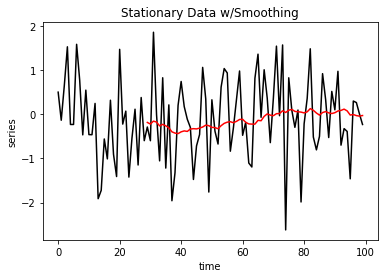

In [ ]:
smoothed_stationary = moving_average(stationary, window=30, forecast=False)

plt.plot(time, stationary, 'k-',label='Trend')
plt.title('Stationary Data w/Smoothing')
plt.xlabel('time')
plt.ylabel('series')
plt.plot(time[29:], smoothed_stationary, 'r', label="smooth")

The larger window seems to help, so one thing to keep in mind when using smoothing methods is to understand the effect of window size.

A window size that is too small, will not be able to smooth out the noise. On the other hand, a window size that is too large might remove interesting trends or seasonalities.

### Trend

Note in the trend that there is a slight lag between the time series and the smoothed time series. Technically, the window approximates the value in the middle of the window. Thus, there will always be a lag of half the window size, which we can also recompensate for when we plot by shifting the output.

However, in practice, we cannot see the future. Thus, we usually just use the previous values in the calculation.

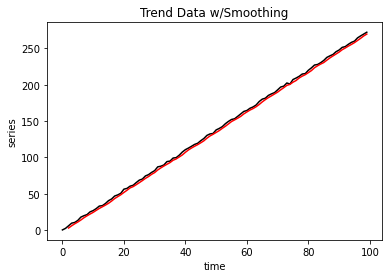

In [ ]:
smoothed_trend = moving_average(trend, window=3, forecast=False)

plt.plot(time, trend, 'k-',label='Trend')
plt.title('Trend Data w/Smoothing')
plt.xlabel('time')
plt.ylabel('series')
plt.plot(time[2:], smoothed_trend, 'r', label="smooth")

A larger window causes a larger lag.

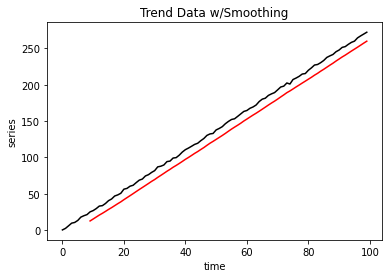

In [ ]:
smoothed_trend = moving_average(trend, window=10, forecast=False)

plt.plot(time, trend, 'k-',label='Trend')
plt.title('Trend Data w/Smoothing')
plt.xlabel('time')
plt.ylabel('series')
plt.plot(time[9:], smoothed_trend, 'r', label="smooth")

### Seasonality

Note how smoothing can reduce the peak in seasonality data. If we increase the window size to be very large (compared to the lenght of the season), the seasonality will disappear. 

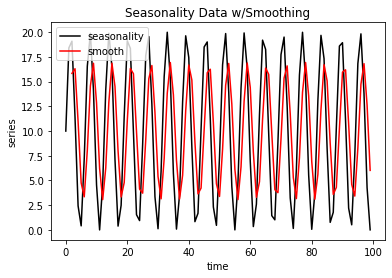

In [ ]:
smoothed_seasonality = moving_average(seasonality, window=3, forecast=False)

plt.plot(time, seasonality, 'k-',label='seasonality')
plt.title('Seasonality Data w/Smoothing')
plt.xlabel('time')
plt.ylabel('series')
plt.plot(time[2:], smoothed_seasonality, 'r', label="smooth")
plt.legend(loc='upper left');

### Trend & seasonality

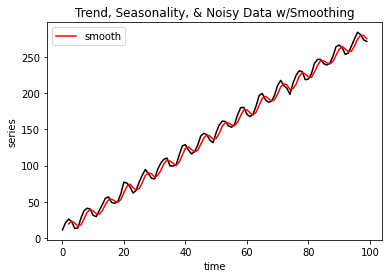

In [ ]:
smoothed_trend_seasonality = moving_average(trend_seasonality, window=3, forecast=False)

plt.plot(time, trend_seasonality, 'k-')
plt.title("Trend, Seasonality, & Noisy Data w/Smoothing")
plt.xlabel('time')
plt.ylabel('series')
plt.plot(time[2:], smoothed_trend_seasonality, 'r', label="smooth")
plt.legend(loc='upper left');

### Exponentially increasing data

Simple moving average smoothing cannot follow exponentially moving trends very well.

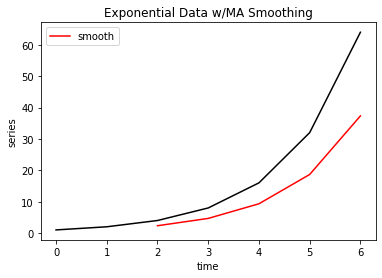

In [ ]:
ma_smoothed_exp_trend = moving_average(exp_trend, window=3, forecast=False)

plt.plot(t, exp_trend, 'k-')
plt.title("Exponential Data w/MA Smoothing")
plt.xlabel('time')
plt.ylabel('series')
plt.plot(t[2:], ma_smoothed_exp_trend, 'r', label="smooth")
plt.legend(loc='upper left');

## Smothing with non-uniform weights

Instead of weighting every value in the window the same, we can try to give more weights to recent values instead.

This is still not exponential moving average we learned in lecture, but just an example to give you a better sense.

Instead of equal weights of [0.333, 0.333, 0.333], here we will use [0.160, 0.294, 0.543].

This is found from the equation:

$w_t + w_{t-1}^2 + w_{t-2}^3 = 1$

In [ ]:
def numa(observations, forecast=True):
    '''returns the non-uniformly weighted smoothed version of an array of observations.'''
    weights = np.array([0.160, 0.294, 0.543])
    output = np.zeros_like(observations, dtype='float')
    for i, _ in enumerate(observations):
        if (i == 0) or (i == 1):
            pass
        else:
            output[i] = np.dot(observations[i-2:i+1], weights)
    output = output[2:]
    if forecast:
        return np.append(output, np.ones(3)*output[-1])
    else:
        return output

As shown below, the non-uniform weights can better track a exponentially increasing function. Next we will look into how exponential moving average works.

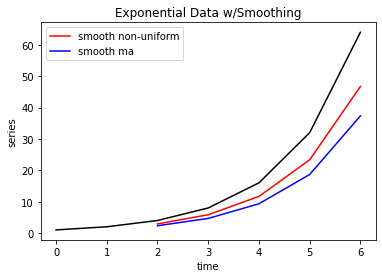

In [ ]:
numa_smoothed_exp_trend = numa(exp_trend, forecast=False)
# t = np.arange(len(values))

plt.plot(t, exp_trend, 'k-')
plt.title("Exponential Data w/Smoothing")
plt.xlabel('time')
plt.ylabel('series')
plt.plot(t[2:], numa_smoothed_exp_trend, 'r', label="smooth non-uniform")
plt.plot(t[2:], ma_smoothed_exp_trend, 'b', label="smooth ma")
plt.legend(loc='upper left');

---

# Section 2: Exponentially weighted moving average
In this section, we will explain exponential smoothing as we learned in class.

## Three Types of Exponential Smoothing

#### Single Exponential
This method is useful if your data does not have trend nor seasonality, and you want to approximately track patterns in your data. Furthermore, this method reduces the lag associated with the moving average techniques discussed above. 

#### Double Exponential 
If your data exhibit a trend, use this smoothing method. It has all the benefits of Single Exponential with the ability to pickup on trend. 

#### Triple Exponential
If your data exhibit trend and seasonality, use this smoothing method. It has all the benefits of Double Exponential with the ability to pickup on seasonality. 

Next we will use the trend+seasonality time series to showcase these methods. As usual, **statsmodels** already implemented all of the methods we will use. We will also use the smoothing methods to predict ahead for 5 time steps.

In [ ]:
time = np.arange(len(trend_seasonality))
test_size = 5
# Take out the last 5 values to create a training data.
train = trend_seasonality[:-test_size]
test = trend_seasonality[-test_size:]

## Single Exponential

In statsmodels, exponential smoothing can be expressed recursively as

$S_t = \alpha x_{t-1} + (1-\alpha)S_{t-1} $

$S_0 = $initial value

(Note the slight difference in indexing between lecture and here. For more information on the formulation see [link](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html). This website is a very good resource in general. I highly recommend anyone who are interested in time series to study further there.)

Thus, to create a single exponential smoothing model. We need to define two things; smoothing parameter, $\alpha$, and how the initial value is initialized. For initialization, there are many strategies such as takes the first value or takes an average of the first few values.

Before we go into more details, let's see statsmodels in action first.

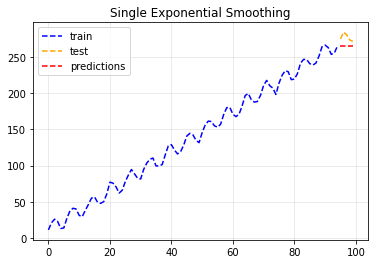

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing

single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))

plt.plot(time[:-test_size], train, 'b--', label="train")
plt.plot(time[-test_size:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-test_size:], single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Single Exponential Smoothing")
plt.grid(alpha=0.3)

There is a lot happening in the previous code block. First to use the smoothing, we simply **fit** the training data. Then, we can use **forecast** to predict the future for X steps.

For single exponential it can only predict using the latest average value as shown in the plot.

To see the smoothed results in the training data use **predict** in the region that is trained on. The reason the term "predict" is used is because it is trying to predict $x_t$ using information from before time $t$.

In [ ]:
# Let's look at the smoothed values inside the training data.
print(single.predict(1,10))
print(train[0:10])

[10.99342831 20.88818125 25.88835134 22.70725979 12.9636683  13.69248334
 26.86427065 37.35473545 40.95463369 39.95630494]
[10.99342831 20.88818125 25.88835134 22.70725979 12.9636683  13.69248334
 26.86427065 37.35473545 40.95463369 39.95630494]


The smoothed values and the original data are exactly the same! What happened?

When we fit the model, we passed in the flag **optimized=True** which means that statsmodel will try to find the optimal hyperparameters for your model automatically. This is similar to supervised learning where you try to minimize the error in the training data.

Let's see the optimal values it found.

In [ ]:
single.params

{'damping_slope': nan,
 'initial_level': 10.993428306022466,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': nan,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 1.0,
 'smoothing_seasonal': nan,
 'smoothing_slope': nan,
 'use_boxcox': False}

Turns out it uses smoothing_level = 1. This is our alpha hyperparameter. This means that the smooth version will simply take the current value from the time series. Let's try setting alpha to 0.5, and see how the smoothing is now a smoothed version.

In general the smaller the alpha, the smoother the smoothed time series will be.

In [ ]:
single2 = SimpleExpSmoothing(train).fit(optimized=True,smoothing_level=0.5)
print("smoothing_level",single2.params['smoothing_level'])
print("single_fixed    ",single2.predict(1,10))
print("single_optimized",single.predict(1,10))
print("original        ",train[0:10])

smoothing_level 0.5
single_fixed     [13.74719681 17.31768903 21.60302019 22.15513999 17.55940414 15.62594374
 21.2451072  29.29992132 35.12727751 37.54179122]
single_optimized [10.99342831 20.88818125 25.88835134 22.70725979 12.9636683  13.69248334
 26.86427065 37.35473545 40.95463369 39.95630494]
original         [10.99342831 20.88818125 25.88835134 22.70725979 12.9636683  13.69248334
 26.86427065 37.35473545 40.95463369 39.95630494]


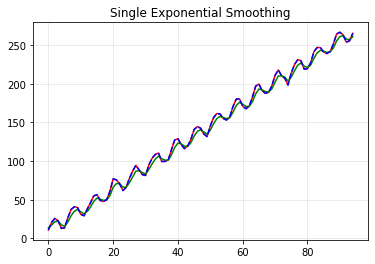

In [ ]:
plt.plot(time[:-test_size], single.predict(1,len(train)), 'r', label="single_optimized")
plt.plot(time[:-test_size], single2.predict(1,len(train)), 'g', label="single_fixed")
plt.plot(time[:-test_size], train, 'b--', label="train")
plt.title("Single Exponential Smoothing")
plt.grid(alpha=0.3)

## Double Exponential

Now let's try to use the double exponential method.

Notice how the prediction can capture the trend.

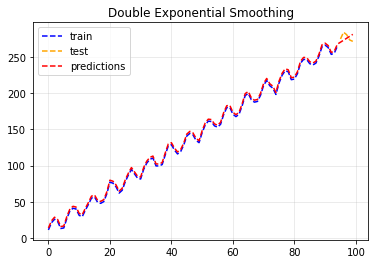

In [ ]:
from statsmodels.tsa.api import Holt

double = Holt(train).fit(optimized=True)
# # OR use this :
# double = ExponentialSmoothing(train,
#                               trend="additive").fit(optimized=True)

double_preds = double.predict(1,len(time))

plt.plot(time[:-test_size], train, 'b--', label="train")
plt.plot(time[-test_size:], test, color='orange', linestyle="--", label="test")
plt.plot(time, double_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing")
plt.grid(alpha=0.3);

In [ ]:
# Now our params have both level and slope.
double.params

{'damping_slope': nan,
 'initial_level': 8.288447354867834,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': 2.704997188908326,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 1.0,
 'smoothing_seasonal': nan,
 'smoothing_slope': 0.0,
 'use_boxcox': False}

## Triple Exponential

Now let's try to use the double exponential method.

Notice how the prediction can capture the seasonality.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


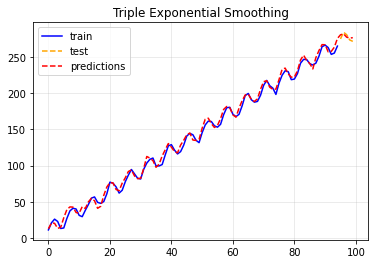

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

# Here we set period = 13. The original data has a peroid of 6.28 (2pi). 
# statsmodels only accepts integer values for periods. We can put 6 here.
# However, it just turns out that 13 gives a "better" model.
triple = ExponentialSmoothing(train, trend='additive', seasonal='additive',
                              seasonal_periods=13).fit(optimized=True)
triple_preds = triple.predict(1,len(time))


plt.plot(time[:-test_size], train, 'b', label="train")
plt.plot(time[-test_size:], test, color='orange', linestyle="--", label="test")
plt.plot(time, triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

In [ ]:
triple.params

{'damping_slope': nan,
 'initial_level': 119.8887533066723,
 'initial_seasons': array([-122.92367735, -114.78797827, -111.42364574, -115.692545  ,
        -125.94544302, -126.91484879, -115.86274494, -106.8380357 ,
        -105.12300691, -107.35716264, -116.60136605, -118.76005727,
        -110.73836482]),
 'initial_slope': 2.1726908616124128,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.2631578922483996,
 'smoothing_seasonal': 0.7368421027747153,
 'smoothing_slope': 0.04357018923818231,
 'use_boxcox': False}

---


# Section 3: Smoothing with Air-Passengers dataset

In this section, we will apply smoothing methods to the **Air-Passengers dataset**.

We will apply log transform to turn this into an additive series.

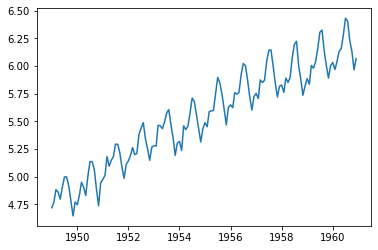

In [ ]:
path = "AirPassengers.csv"
dataset = pd.read_csv(path)
#Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'],infer_datetime_format=True) #convert from string to datetime
indexedDataset = dataset.set_index(['Month'])
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

In [ ]:
test_size = 10
train = np.array(indexedDataset_logScale['#Passengers'][:-test_size])
test = np.array(indexedDataset_logScale['#Passengers'][-test_size:])
time = np.array(dataset['Month'], dtype='datetime64[M]')

## Single Exponential

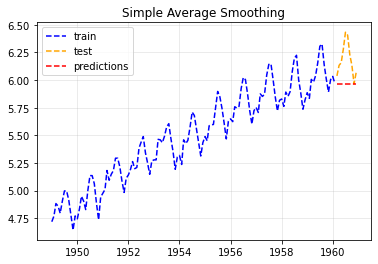

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing
single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))

plt.plot(time[:-test_size], train, 'b--', label="train")
plt.plot(time[-test_size:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-test_size:], single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Simple Average Smoothing")
plt.grid(alpha=0.3);


## Double Exponential

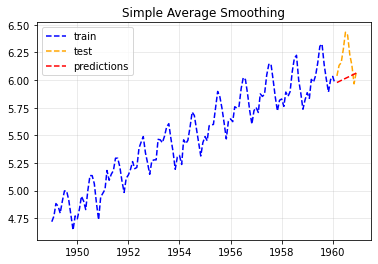

In [ ]:
from statsmodels.tsa.api import Holt
double = Holt(train).fit(optimized=True)

double_preds = double.forecast(len(test))

plt.plot(time[:-test_size], train, 'b--', label="train")
plt.plot(time[-test_size:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-test_size:], double_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Simple Average Smoothing")
plt.grid(alpha=0.3);

## Triple Exponential

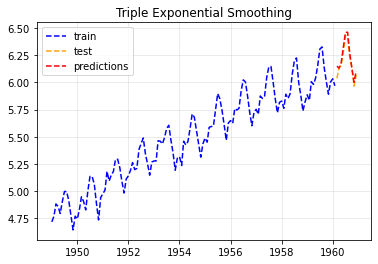

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing
triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=12).fit(optimized=True)
triple_preds = triple.forecast(len(test))

plt.plot(time[:-test_size], train, 'b--', label="train")
plt.plot(time[-test_size:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-test_size:], triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

To obtain the final predictions we can convert the values back by taking the exponent. We can compare the final results between the three methods.

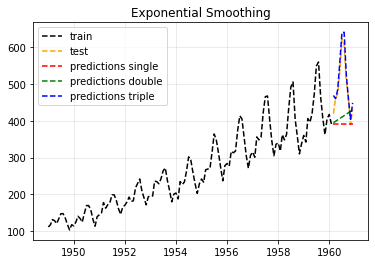

In [ ]:
plt.plot(time[:-test_size], np.exp(train), 'k--', label="train")
plt.plot(time[-test_size:], np.exp(test), color='orange', linestyle="--", label="test")
plt.plot(time[-test_size:], np.exp(single_preds),'r--', label="predictions single")
plt.plot(time[-test_size:], np.exp(double_preds), 'g--',label="predictions double")
plt.plot(time[-test_size:], np.exp(triple_preds), 'b--',label="predictions triple")

plt.legend(loc='upper left')
plt.title("Exponential Smoothing")
plt.grid(alpha=0.3);

Of course, we can also perform the smoothing in the original series by setting the trend and seasonal component to multiplicative.

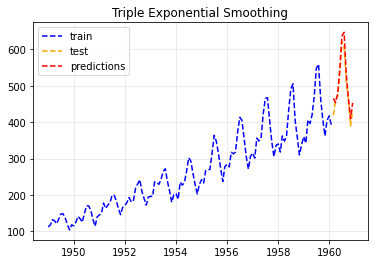

In [ ]:
train_orig = np.array(indexedDataset['#Passengers'][:-test_size])
test_orig = np.array(indexedDataset['#Passengers'][-test_size:])

triple_orig = ExponentialSmoothing(train_orig,
                              trend="multiplicative",
                              seasonal="multiplicative",
                              seasonal_periods=12).fit(optimized=True)
triple_orig_preds = triple_orig.forecast(len(test))

plt.plot(time[:-test_size], train_orig, 'b--', label="train")
plt.plot(time[-test_size:], test_orig, color='orange', linestyle="--", label="test")
plt.plot(time[-test_size:], triple_orig_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

From the results, we can see that our prediction is the best using triple exponential since the data has both trend and seasonality.

In the next chapter we will talk more about more advanced prediction methods and how to objectively compare the performance between models.
